# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1ODNIop8fHmgjHBIhjeenH38FWK7-DDZk

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [4]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [5]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


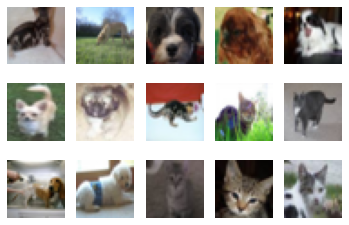

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    print(image.shape)
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [16]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8000
2000
2000
<class 'torchvision.datasets.cifar.CIFAR10'>


We have 8000 training examples, 2000 validation exmaples and 2000 test examples.

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

Validation set acts as an itermediary and allows us to see how our trained model would perform on unseeen data. We can then improve our model based on the results on the validation set. Note that we can't do modify our model after running the test set, so we use validation to get a sense of how well our model can generalize. Only training on the training data doesn't give us any insight on how our model would perform on new, unseen data and would be inssuficient. So we train on training data, run on validation set and tune parameters and run on test data for final results.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [21]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        print("IN X", x.shape)
        return x

In [8]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [22]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


There are (5x3x3x3)+5+245+1=386 parameters in small_net.

In [ ]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


There are (5x3x5x5)+5+(10x5x5x5)+10+(32x250)+32+32+1=9705 parameters in large_net

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [10]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
          # Get the inputs
          inputs, labels = data
          labels = normalize_label(labels) # Convert labels to 0/1
          # Zero the parameter gradients
          optimizer.zero_grad()
          # Forward pass, backward pass, and optimize
          print("INS", inputs.shape)
          outputs = net(inputs)
          print("OUT", outputs.shape)
          loss = criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()
          # Calculate the statistics
          corr = (outputs > 0.0).squeeze().long() != labels
          total_train_err += int(corr.sum())
          total_train_loss += loss.item()
          total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    # np.savetxt("{}_train_err.csv".format(model_path), train_err)
    # np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    # np.savetxt("{}_val_err.csv".format(model_path), val_err)
    # np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

batch_size is 64, learning_rate is 0.01, num_epochs is 30 by default

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [23]:
train_net(large_net, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 32, 32])
IN X torch.Size([64])
OUT torch.Size([64])
INS torch.Size([64, 3, 3

KeyboardInterrupt: ignored

There are 9 files saved to disk: 

model_small_bs64_lr0.01_epoch0-> Checkpoint at epoch 0 

model_small_bs64_lr0.01_epoch1-> Checkpoint at epoch 1 

model_small_bs64_lr0.01_epoch2-> Checkpoint at epoch 2 

model_small_bs64_lr0.01_epoch3-> Checkpoint at epoch 3 

model_small_bs64_lr0.01_epoch4-> Checkpoint at epoch 4 

model_small_bs64_lr0.01_epoch4_train_err.csv-> Contains the training set error for all 5 epochs 

model_small_bs64_lr0.01_epoch4_train_loss.csv-> Contains the training set loss for all 5 epochs 

model_small_bs64_lr0.01_epoch4_val_err.csv-> Contains the validation set error for all 5 epochs 

model_small_bs64_lr0.01_epoch4_val_loss.csv-> Contains the validation set loss for all 5 epochs 


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43125, Train loss: 0.6785536618232727 |Validation err: 0.3685, Validation loss: 0.6557822246104479
Epoch 2: Train err: 0.355875, Train loss: 0.6373494830131531 |Validation err: 0.365, Validation loss: 0.6371175236999989
Epoch 3: Train err: 0.329625, Train loss: 0.6132430391311645 |Validation err: 0.3275, Validation loss: 0.6111147180199623
Epoch 4: Train err: 0.321625, Train loss: 0.599531069278717 |Validation err: 0.3395, Validation loss: 0.6107181664556265
Epoch 5: Train err: 0.31175, Train loss: 0.5910293288230896 |Validation err: 0.3335, Validation loss: 0.6047780904918909
Epoch 6: Train err: 0.30275, Train loss: 0.5815559849739075 |Validation err: 0.325, Validation loss: 0.6079260371625423
Epoch 7: Train err: 0.3055, Train loss: 0.5805613555908203 |Validation err: 0.3335, Validation loss: 0.5988940559327602
Epoch 8: Train err: 0.29675, Train loss: 0.5729042272567749 |Validation err: 0

The small_net took 129.84 seconds and the large_net took 148.5 seconds. This was expected since the large_net has more paramteres.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

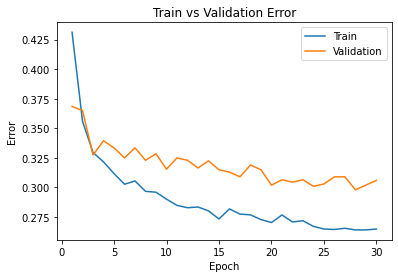

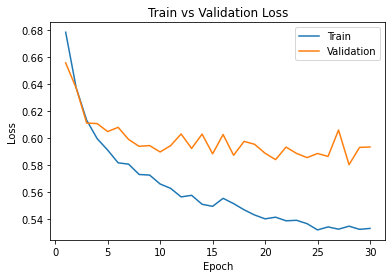

In [ ]:
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29);
plot_training_curve(small_model_path);

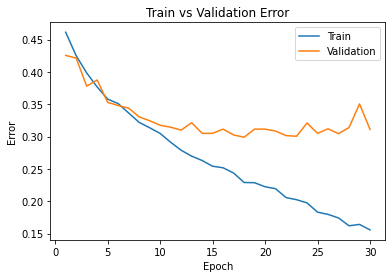

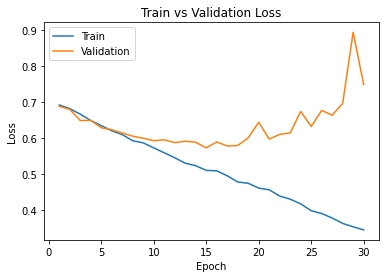

In [ ]:
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29);
plot_training_curve(large_model_path);

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

For both loss and error in the small net, we see the model underfitting initially, for the first 5 epochs. But then we notice that while the training error and loss coniously gets smaller with more epochs, the validations error and loss stabilize and stop decreasing after around 10 epochs. This makes sense because the model is overfitting on the training set after 10 epochs which doesn't generalize well as seen on the validation set.  
It's a smiliar trend for the large net, and we even see the validation loss increase after 20 epochs due to overfitting.  
While the trends are almost the same, we see that small net gets a lower final validation error and loss.


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001);

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6945205240249633 |Validation err: 0.491, Validation loss: 0.6929903607815504
Epoch 2: Train err: 0.50225, Train loss: 0.6930275931358337 |Validation err: 0.491, Validation loss: 0.6924116816371679
Epoch 3: Train err: 0.487375, Train loss: 0.6922533187866211 |Validation err: 0.4765, Validation loss: 0.6920256800949574
Epoch 4: Train err: 0.448625, Train loss: 0.6916869764328003 |Validation err: 0.4515, Validation loss: 0.6913820113986731
Epoch 5: Train err: 0.44225, Train loss: 0.6910718812942505 |Validation err: 0.4415, Validation loss: 0.6910950168967247
Epoch 6: Train err: 0.44025, Train loss: 0.6903757758140564 |Validation err: 0.437, Validation loss: 0.6905075237154961
Epoch 7: Train err: 0.43825, Train loss: 0.6895534009933472 |Validation err: 0.434, Validation loss: 0.6896947920322418
Epoch 8: Train err: 0.439, Train loss: 0.6884737334251404 |Validation err: 0.43

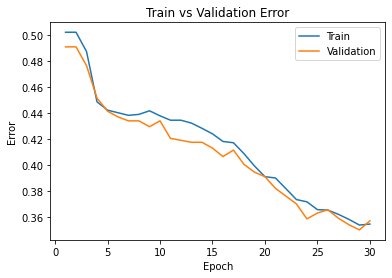

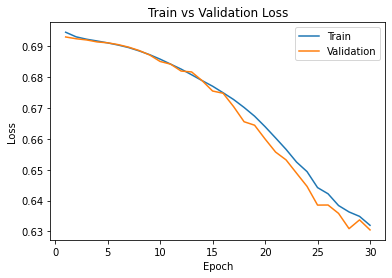

In [ ]:
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29);
plot_training_curve(large_model_path)

The model was 20 seconds faster with the smaller learning rate but it resulted in a slightly higher validation error (previously 0.32 and now 0.35) and a much higher training error (previously 0.16 and now 0.35). In terms of loss, the training loss increased by a lot again (previously 0.35 and now 0.63) while the validation loss actually decreased (previously 0.75 and now 0.63). Overall, lowering the learning rate didn't increase performance in this case. 

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.394375, Train loss: 0.6583439974784852 |Validation err: 0.3665, Validation loss: 0.6302683055400848
Epoch 2: Train err: 0.35475, Train loss: 0.6260433626174927 |Validation err: 0.3525, Validation loss: 0.6150094550102949
Epoch 3: Train err: 0.33775, Train loss: 0.6079716925621033 |Validation err: 0.351, Validation loss: 0.6075180452316999
Epoch 4: Train err: 0.312625, Train loss: 0.5837899551391602 |Validation err: 0.33, Validation loss: 0.6287574917078018
Epoch 5: Train err: 0.308375, Train loss: 0.5802531237602234 |Validation err: 0.337, Validation loss: 0.6012802347540855
Epoch 6: Train err: 0.295375, Train loss: 0.5642361807823181 |Validation err: 0.32, Validation loss: 0.6204832252115011
Epoch 7: Train err: 0.289, Train loss: 0.5474876840114593 |Validation err: 0.3045, Validation loss: 0.6010499075055122
Epoch 8: Train err: 0.281125, Train loss: 0.5377589094638825 |Validation err: 0.3

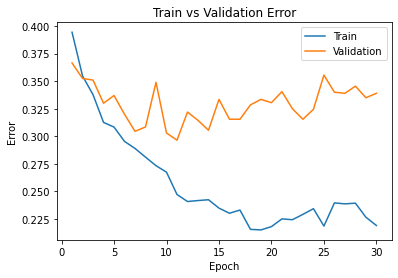

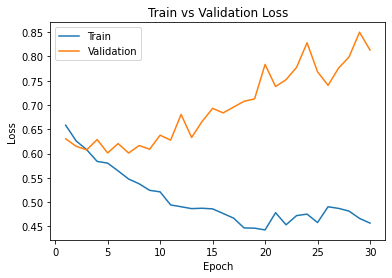

In [ ]:
train_net(large_net, learning_rate=0.1);
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29);
plot_training_curve(large_model_path)

The training took roughly the same amount of time compared to lr=0.01 (only 5s faster). All errors and losses were slighly increased:  
training error 0.15 -> 0.225. 

training loss 0.35 -> 0.45. 

validation error 0.32 -> 0.34. 

validation loss 0.7 -> 0.8. 

Increasing the learning rate didn't increase performance in this case. either.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

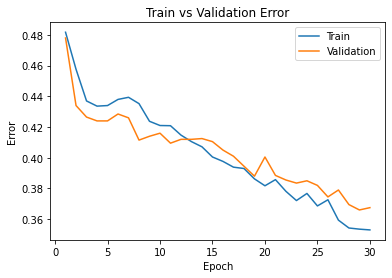

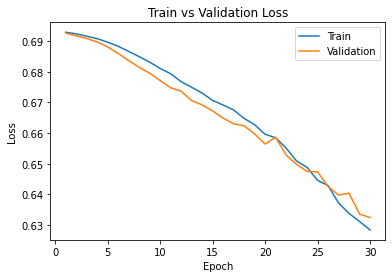

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512);
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29);
plot_training_curve(large_model_path);

This model was about 37 seconds faster, which is due to larger batch size and so the iteration time is lower in each epoch. Our validation error was increased by 0.5 but  the validation loss went from 0.7 to roughly 0.635. It did however increase both training loss and error (by 0.2 and 0.3 respectively). So while our losses and errors didn't gravely change, the model was at least faster.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.363, Train loss: 0.6344954698681832 |Validation err: 0.3355, Validation loss: 0.6145865290164948
Epoch 2: Train err: 0.328, Train loss: 0.607265090227127 |Validation err: 0.335, Validation loss: 0.6043757331371308
Epoch 3: Train err: 0.31175, Train loss: 0.5827661495804787 |Validation err: 0.3375, Validation loss: 0.6208900046348572
Epoch 4: Train err: 0.30075, Train loss: 0.565795996427536 |Validation err: 0.3265, Validation loss: 0.5904141414165497
Epoch 5: Train err: 0.283375, Train loss: 0.5441598464846611 |Validation err: 0.317, Validation loss: 0.5839998676776886
Epoch 6: Train err: 0.2755, Train loss: 0.5298555326461792 |Validation err: 0.3225, Validation loss: 0.6016495614051819
Epoch 7: Train err: 0.253125, Train loss: 0.5128447062075138 |Validation err: 0.3075, Validation loss: 0.5765719130039215
Epoch 8: Train err: 0.247875, Train loss: 0.49917483794689177 |Validation err: 0.332

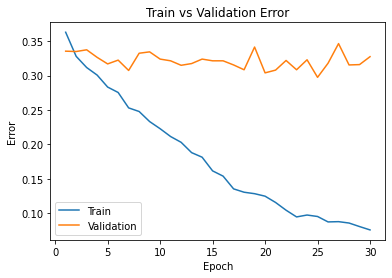

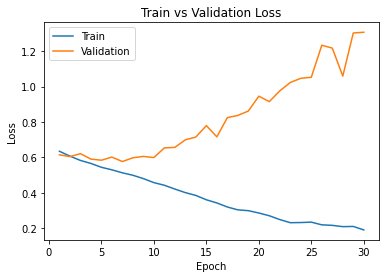

In [ ]:
train_net(large_net, batch_size=16);
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29);
plot_training_curve(large_model_path)

As expected this model took much (33s) longer due to the smaller batch size. While decreasing the training error and loss (by 0.05 and 0.15 respectively) it had a poor performance on the validation error and loss since they increased 0.1 and 0.6 respectively. The model took longer and left us with worse results, therefore decreasing batch size doesn't improve the performance in our case.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Since chainging the learning rate didn't affect the large net much we can keep using 0.01 but use a larger batch size to increase speed and also use the small net since the it had slighly lower validation loss and error.  
small_net, learning_rate=0.01, batch_size = 128

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454625, Train loss: 0.688547965080019 |Validation err: 0.4325, Validation loss: 0.6814442425966263
Epoch 2: Train err: 0.4175, Train loss: 0.6753699164541941 |Validation err: 0.384, Validation loss: 0.667011633515358
Epoch 3: Train err: 0.38225, Train loss: 0.6581908265749613 |Validation err: 0.3595, Validation loss: 0.6496157832443714
Epoch 4: Train err: 0.3635, Train loss: 0.6404415236579047 |Validation err: 0.3535, Validation loss: 0.6349382698535919
Epoch 5: Train err: 0.346, Train loss: 0.6248405064855304 |Validation err: 0.347, Validation loss: 0.6266033500432968
Epoch 6: Train err: 0.3315, Train loss: 0.6116761508442107 |Validation err: 0.3425, Validation loss: 0.6188973374664783
Epoch 7: Train err: 0.32775, Train loss: 0.6060109573697287 |Validation err: 0.343, Validation loss: 0.6157672144472599
Epoch 8: Train err: 0.316875, Train loss: 0.5966830367133731 |Validation err: 0.3335, 

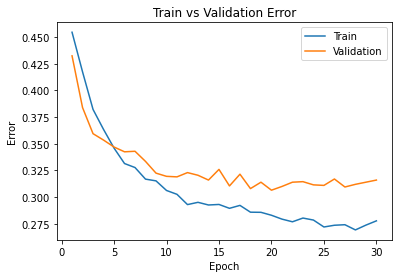

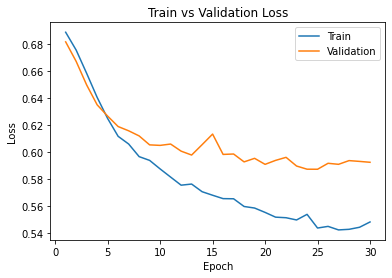

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=128);
small_model_path = get_model_name("small", batch_size=128, learning_rate=0.01, epoch=29);
plot_training_curve(small_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

The hyperparamters above made the training 22 seconds faster and the plots smoother but all the errors and losses are unchanged. So this time we will keep the using small_net, and 128 or batch_size but lower the learning rate.  
small_net, learnig_rate = 0.005, batch_size = 128

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.468625, Train loss: 0.6908236969084967 |Validation err: 0.436, Validation loss: 0.685748029500246
Epoch 2: Train err: 0.433, Train loss: 0.6834235077812558 |Validation err: 0.4095, Validation loss: 0.6796621643006802
Epoch 3: Train err: 0.41625, Train loss: 0.6766141917970445 |Validation err: 0.3865, Validation loss: 0.6720090210437775
Epoch 4: Train err: 0.395, Train loss: 0.6682078951881045 |Validation err: 0.3955, Validation loss: 0.6628281734883785
Epoch 5: Train err: 0.384375, Train loss: 0.659145544445704 |Validation err: 0.3865, Validation loss: 0.6565625630319118
Epoch 6: Train err: 0.369, Train loss: 0.6487330179365854 |Validation err: 0.3635, Validation loss: 0.6456811726093292
Epoch 7: Train err: 0.35875, Train loss: 0.6391496005512419 |Validation err: 0.354, Validation loss: 0.6379922814667225
Epoch 8: Train err: 0.3495, Train loss: 0.630687625635238 |Validation err: 0.35, Vali

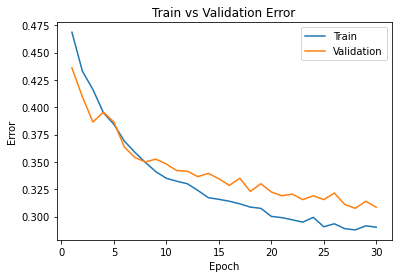

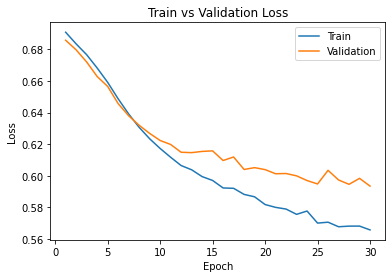

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=128, learning_rate=0.005);
small_model_path = get_model_name("small", batch_size=128, learning_rate=0.005, epoch=29);
plot_training_curve(small_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.005, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

small_net had lower validation loss and error from the beginning compared to large_net and even in part large_net was never able to acheive small_net's results so small_net is the net to choose.  

Increasing atch size speeds up training in all examples without increasing the validation loss and error and gives us smoother plots, hence a moderetly larger batch_size such as 128 improves our efficiency and performance. 

Learning rate didn't seem to gravely affect our loss and error but its slight decrease does give us lower validation loss and error.  

30 is suitable for epoch_number, since when too small it can lead to underfitting and when too large it would overfit.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

testing = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, testing)

print("test error: ", test_err)
print("test loss: ", test_loss)

val_err, val_loss = evaluate(net, val_loader, testing)
print("validation error: ", val_err)
print("validation loss: ", val_loss)

Files already downloaded and verified
Files already downloaded and verified
test error:  0.2905
test loss:  0.5668027400970459
validation error:  0.3085
validation loss:  0.5933956019580364


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

Contrary to our expectation, the test error and loss are slighlty less that validation error and loss (0.018 and 0.027 respectively).  
Usually we expect validation error and loss to be lower because we refine our hyperparameters after seeing the validation error and loss and try to imporve them. But we don't do this for our test set and we only run it once after all the tunings for the finale results. So we would expect test error and loss to be higher than validation but by conincidence that is not the case here.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The entire purpose of test data is to give an unbiased estimate of model's accuracy. So if we keep tuning are parameters after it, we're leaking data. And even if we do end up with better results they will not be a good indication of how our model would perform on data it has never seen before.

### Part (f) - 5pt

How does your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.419125, Train loss: 0.6714658339818319 |Validation err: 0.398, Validation loss: 0.6582800447940826
Epoch 2: Train err: 0.379875, Train loss: 0.6492340470117236 |Validation err: 0.388, Validation loss: 0.6514426842331886
Epoch 3: Train err: 0.366375, Train loss: 0.6378535997299921 |Validation err: 0.3815, Validation loss: 0.6482101641595364
Epoch 4: Train err: 0.359625, Train loss: 0.6295622643970308 |Validation err: 0.392, Validation loss: 0.6536959111690521
Epoch 5: Train err: 0.348875, Train loss: 0.6239601411516704 |Validation err: 0.3795, Validation loss: 0.6437500938773155
Epoch 6: Train err: 0.3345, Train loss: 0.6150485759689694 |Validation err: 0.379, Validation loss: 0.6476834565401077
Epoch 7: Train err: 0.331125, Train loss: 0.6087291429913233 |Validation err: 0.3795, Validation loss: 0.6448529027402401


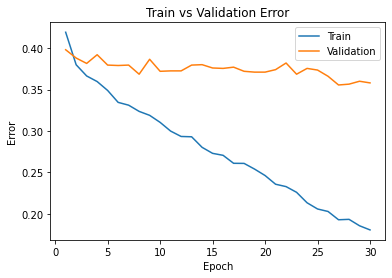

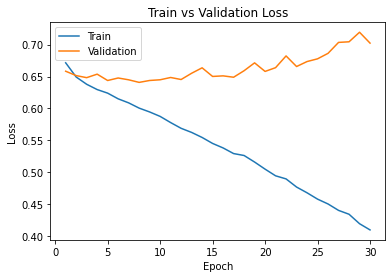

Test Error: 0.2905
Test Loss: 0.5673177167773247


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze()

pigeon = Pigeon()

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

train_net(pigeon,batch_size=128,learning_rate=0.005,num_epochs=30)
ann_model_path = get_model_name("pigeon", batch_size=128, learning_rate=0.005, epoch=29)
plot_training_curve(ann_model_path)

testing = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, testing)

print("Test Error:", test_err)
print("Test Loss:", test_loss)

The ANN training was much faster than CNN (under 100s) but the CNN yeilds slightly better results. Though the results are similar here, CNN is better for image classification compared to ANN especially for bigger datasets.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab2_Cats_vs_Dogs.ipynb

[NbConvertApp] Converting notebook /content/Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 962091 bytes to /content/Lab2_Cats_vs_Dogs.html
